# Eucalc
**Authors**: V. Lebovici, H. Passe

In this notebook, we provide a detailed introduction to our ```C++``` / ```Python``` library ```Eucalc```, which implements algorithms to compute Euler characteristic transform, Radon transform and hybrid transforms on cubical complexes. For more details, see [our paper](https://arxiv.org/abs/2405.02256).

**NB:** For more straightforward examples containing the minimal number of lines to compute topological integral transforms, see each one of the specific tutorials ```euler_characteristic_transform.ipynb```, ```hybrid_transform.ipynb```, ```radon_transform.ipynb```.

---

**Preliminary:** adding the right folder to path.

In [1]:
import sys
sys.path.append('..')

### Weighted cubical complexes
A *cube* of $\mathbb{R}^n$ is a subset $C = [a_1,b_1]\times\dots\times [a_n,b_n] \subseteq \mathbb{R}^n$ such that $b_i - a_i = b_j - a_j$ whenever $a_i \neq b_i$ and $a_j \neq b_j$. A *cubical complex* is simply a finite collection $\mathcal{C}$ of cubes, called *cells*, such that:
- $\emptyset\in\mathcal{C}$,
- if $C\in\mathcal{C}$ and $C'$ is a face of $C$, then $C'\in \mathcal{C}$,
- if $C,C'\in\mathcal{C}$, then $C\cap C'\in\mathcal{C}$.

The *dimension* of a cube the number of indices $i\in\{1,\ldots,n\}$ such that $a_i \neq b_i$. 

A *weighted cubical complex* is the data of a cubical complex together with an integer value associated to each one of its cells, that is, a function $\varphi:\mathcal{C}\to \mathbb{Z}$.

We illustrate this definition with examples of weighted and unweighted cubical complexes. In grey we plot the cube of dimension two, in green cubes of dimension one, and in blue cubes of dimension zero.

![Examples of cubical complexes](img/cubical_complexes.png)

### From digital images to weighted cubical complexes
As explained in our paper, our implementation of weighted cubical complexes consists in a ```C++``` class ```EmbeddedComplex``` that inherits from the cubical complex class ```Bitmap_cubical_complex``` from the ```GUDHI``` library and additionally stores the embedding coordinates of the vertices in $\mathbb{R}^n$. 
By convention, the embedding coordinates of the vertices in $\mathbb{R}^n$ are evenly spaced and normalized in $[−0.5, 0.5]^n$. 
By default, one top-dimensional cell is associated to each pixel of the image and the values of lower-dimensional cells are equal to the maximum of the values of their cofaces, that is:
$$\varphi(C) = \max_{C'\supset C} \varphi(C').$$

We illustrate the construction of a cubical complex from a 2D digital image below. Consider the following greyscale image:

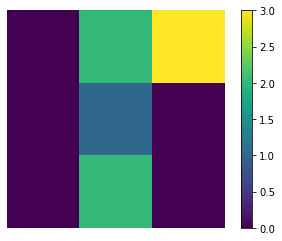

In [1]:
import numpy as np
import matplotlib.pyplot as plt

img = np.array([[0,2,0],[0,1,0],[0,2,3]])
plt.imshow(img, origin='lower')
plt.axis('off')
plt.colorbar()
plt.show()

We can turn it into a weighted cubical complex using our ```EmbeddedComplex``` class.

In [14]:
import eucalc
cplx = eucalc.EmbeddedComplex(img)

Weights of the complex are stored in an array following ```GUDHI```'s convention as detailed in [their documentation](https://gudhi.inria.fr/doc/latest/group__cubical__complex.html). We can print this array:

In [5]:
cplx.print_weights()

AttributeError: 'eucalc.EmbeddedComplex' object has no attribute 'print_weights'

Graphically, the weighted cubical complex looks like:

![Weighted cubical complex from 2D image](img/weighted_cplx_from_img.png)

### Integral transforms
Topological integral transforms of weighted cubical complex are recalled in the Section 2.2 of [our paper](https://arxiv.org/abs/2405.02256). For the sake of illustration, we recall the definition of the Euler characteristic transform in the simpler case of cubical complexes.
In the remaining of this tutorial, we focus on this specific case.

Let $\mathcal{C}$ be a cubical complex. The *Euler characteristic transform* of $\mathcal{C}$ denoted by $\mathrm{ECT}_\mathcal{C}:\mathbb{R}^n\times \mathbb{R}\to\mathbb{Z}$ is defined for each $(\xi,t)\in\mathbb{R}^n\times\mathbb{R}$ by:
$$\mathrm{ECT}_\mathcal{C}(\xi,t) = \chi\big(\mathcal{C}\cap \{\xi\leq t\}\big),$$
where $\{\xi\leq t\} = \{x\in\mathbb{R}^n : \langle \xi,x\mathbb{R}angle = t\}$ and where $\chi$ denotes the Euler characteristic defined by:
$$\chi\big(\mathcal{C}\cap \{\xi\leq t\}\big) = \sum_{C \cap \{\xi\leq t\} \ne \emptyset} (-1)^{\dim C}.$$

### Critical points and values
To speed up computations, our implementation of topological integral transforms computes critical points in the $2^n$ directions $\xi\in\{\pm 1\}^n$. These critical points record the non-trivial changes in Euler characteristic of the sublevel sets $\mathcal{C}\cap \{\xi\leq t\}$ (or level sets for Radon and hybrid transforms) around each vertex of the complex. Critical points and the associated critical values comes in two types, *classical* and *ordinary*, and are defined in the Section 3 of [our paper](https://arxiv.org/abs/2405.02256). The upshot is that after this preprocessing step, the computation of topological integral transforms is linear in the number of critical points. 

Only classical critical points and values and necessary to compute the Euler characteristic transform, see Lemma 2 of [our paper](https://arxiv.org/abs/2405.02256). We can compute them using the class ```EmbeddedComplex``` as follows:

In [15]:
cplx.preproc_ect()

We can then explore the critical points in each direction $\xi\in\{\pm 1\}^n$. Each of these directions is represented by the integer between $0$ and $2^n-1$, called its *index*, whose binary representation is $(\xi + (1,\dots,1))/2$. For instance, when $n=2$ and in the direction $\xi = (1,1)$, we have:

In [16]:
direction = [1,1]
index = cplx.get_vector_index(direction)
print('Index of [1,1]:', index)

Index of [1,1]: 3


Then we can get the classical critical vertices and the classical critical values. Critical vertices are represented by their indices in ```GUDHI```'s [indexing convention](https://gudhi.inria.fr/doc/latest/group__cubical__complex.html).

In [17]:
verts = cplx.get_classical_critical_vertices(index)
vals = cplx.get_classical_critical_values(index)

print('Critical vertices:', verts)
print('Critical values:', vals)

Critical vertices: [2, 30, 32]
Critical values: [2, 1, 1]


We can compute the coordinates of these critical points in $\mathbb{R}^n$ for the given direction, and plot them on the original image:

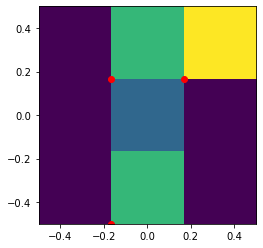

In [18]:
# Computing coordinates of critical points
ptsX,ptsY = [],[]
for v in verts:
    c = cplx.get_coordinates(v)                             # get coordinates from indices of vertices
    ptsX.append(c[0])
    ptsY.append(c[1])

# Plotting the vertices on the image
plt.imshow(img, extent=[-0.5,0.5,-0.5,0.5], origin='lower')
plt.scatter(ptsX, ptsY, color='r')                          # plotting critical points in red
plt.show()

### Exact representation and vectorization of the transform
After the preprocessing step, we can compute an exact representation of the ECT in a given direction.

In [33]:
ect_dir = cplx.compute_euler_characteristic_transform(direction)

We can then evaluate the ECT at each $t\in\mathbb{R}$ as simply as:

In [37]:
t = 0.1
val = ect_dir.evaluate(t)
print('ECT(%s, %d) = %d'%(direction, t, val))


ECT([1, 1], 0) = 3


Hence we can vectorize and plot:

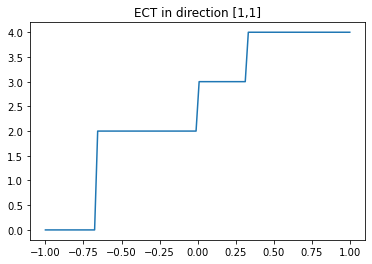

In [53]:
N = 100
T = np.linspace(-1,1,N)
ECT_dir = [ect_dir.evaluate(t) for t in T]

plt.figure()
plt.plot(T,ECT_dir)
plt.title('ECT in direction %s'%direction)
plt.show()